# Tarea 1 - Alexandre Poupeau

First, we need to import some useful libraries that we will use in the notebook.

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

## Exercice 1 - Verisimilitude Maximal

## Exercice 2 - Lineal Regresion

### a) Load and display data

In [48]:
# import the data
data = np.genfromtxt("https://raw.githubusercontent.com/GAMES-UChile/Curso-Aprendizaje-de-Maquinas/master/datos/szege_clima.csv",
                     delimiter=',',
                     skip_header=1)
dataframe = pd.DataFrame(data)
dataframe.columns = ["Humidity", "ThermSens"]
print("Sample of the dataset :\n", dataframe.head(), "\n")

# ambient humidity X
X = np.array(dataframe.loc[:,"Humidity"].values)
mean_X = np.mean(X)
variance_X = np.var(X)
print("Mean X =", mean_X, ", Variance X=", variance_X)

# thermical sensation Y
Y = np.array(dataframe.loc[:,"ThermSens"].values)
mean_Y = np.mean(Y)
variance_Y = np.var(Y)
print("Mean Y =", mean_Y, ", Variance Y=", variance_Y)

Sample of the dataset :
    Humidity  ThermSens
0      0.96   9.355556
1      0.77  10.533333
2      0.53  17.722222
3      0.68  21.116667
4      0.79  10.116667 

Mean X = 0.7278625 , Variance X= 0.02996880609375
Mean Y = 12.972625000000003 , Variance Y= 37.13178540875772


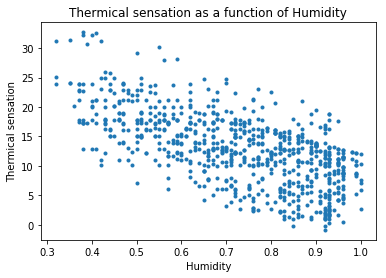

In [34]:
# display the data to get a better idea of what we are working with
plt.plot(X, Y, ".")
plt.title("Thermical sensation as a function of Humidity")
plt.xlabel("Humidity")
plt.ylabel("Thermical sensation")
plt.show()

### b) Model creation

We are going to implement a lineal regression model with ridge regularization.

In [75]:
def reg_lineal(X, Y, p, regul=True):
    """
        Returns the optimal parameter theta for the lineal regression.
        
        Arguments:
            X (array): input
            Y (array): output
            p (float): parameter to control the impact of the regularization
        
        Returns:
            theta_opt (array) : optimal parameter 
    """
    X1 = np.vstack([X,np.ones_like(X)]).T
    
    array_tmp = np.matmul(X1.T, Y)
    mat_tmp = np.matmul(X1.T, X1)
    
    if regul:
        mat_tmp += p*np.identity(mat_tmp.shape[0])
    
    theta = np.dot(np.linalg.inv(mat_tmp), array_tmp)
    
    return theta

In [ ]:
X_train = X 

### c) Coefficients value with different p

Now we are going to plot the value of the parameters a,b (where $\theta = [a, b]$) given different values of $\rho$. a represents the slope and b the intercept.

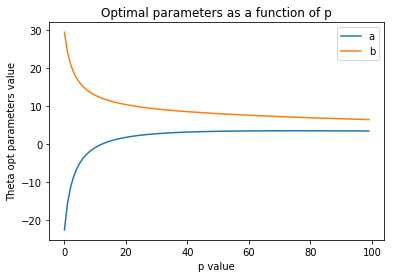

In [121]:
p_array = np.linspace(0, 500, 100)
stock = list()
for p in p_array:
    stock.append(reg_lineal(X, Y, p))
stock = np.array(stock)

plt.plot(stock[:,0], label="a")
plt.plot(stock[:,1], label="b")
plt.title("Optimal parameters as a function of p")
plt.xlabel("p value")
plt.ylabel("Theta opt parameters value")
plt.legend()
plt.show()

## Exercice 3 - Project